In [28]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

#inpath = '/MFMDatasets/MFM_bopf/src/multi_predict/'
#inpath = '/slurm_storage/mbopf/projects/MFM_bopf/src/multi_predict/'
inpath = '/slurm_storage/mbopf/projects/MFM_bopf/src/imbl/'
outdir = '/MFMDatasets/MFM_bopf/src/multi_predict/results/'
#out_flag = True
out_flag = False

#Cutoff_stat = "Fb2_2"
#SORT_STAT = "Fb2_2"
Cutoff_stat = "MCC"
SORT_STAT = "MCC"
#Cutoff_stat = "PR_AUC"
#SORT_STAT = "PR_AUC"
#Cutoff_stat = "ROC_AUC"
#SORT_STAT = "ROC_AUC"
#Cutoff_stat = "precision_2"
#SORT_STAT = "precision_2"

# Cut off value for given stat.
#CUTOFF = 0.2
CUTOFF = 0.0


#alg_cols = ['CLF_time(min)','target','under_alg']
#alg_cols = ['CLF_time(min)','target','pred_alg','under_alg','feats','period','samp_strat']
alg_cols = ['run_time(min)','target','pred_alg','samp_alg','feats','period','samp_strat']
#alg_cols = ['CLF_time(min)','target','pred_alg','under_alg','sample_weights','feats','period']
#alg_cols = ['CLF_time(min)','target','under_alg','samp_strat']
#stat_cols = ['TP','FN','FP','TN','precision_2','recall_2','Spec_2',
#stat_cols = ['TP','FN','FP','TN','NTP','NFN','NFP','NTN','precision_2','recall_2','Spec_2',
#stat_cols = ['NTP','NFN','NFP','NTN','acc','precision_2','recall_2','Spec_2',
#            'ROC_AUC','PR_AUC','MCC','Fb1_2','Fb2_2'
#             ,'Fb05_2','Gmean_2','Gmean_ma','Max Gmean','Max Thresh'
#            ]
stat_cols = ['NTP','NFN','NFP','NTN','acc','precision_1','recall_1','Spec_1',
            'ROC_AUC','PR_AUC','MCC','Fb1_1','Fb2_1'
#             ,'Fb05_2','Gmean_2','Gmean_ma','Max Gmean','Max Thresh'
            ]

#period = "-P*"
period = "-PI"
#period = "-Pre"

#target = "*"
#target = "trans*"
target = "trans_loss"
#target = "transfus_yes"
#target = "high_EBL"

#alg = "LR"
#spec_cols = ['p_C','p_solver']
#spec_cols = ['p_C','p_solver','p_class_weight']

#alg = "NB"
#spec_cols = ['p_var_smoothing']

#alg = "SVC"
#spec_cols = ['p_C','p_kernel','p_degree','p_class_weight','p_gamma']

#alg = "MLP"
#spec_cols = ['p_alpha','p_hidden_layer_sizes']

#alg = "RF"
#spec_cols = ['p_n_estimators','p_max_depth','p_min_samples_leaf','p_min_samples_split']
#spec_cols = ['p_n_estimators','p_max_depth','p_min_samples_leaf','p_min_samples_split',"p_class_weight"]

#alg = "GB"
#spec_cols = ['p_n_estimators','p_max_features','p_min_samples_split','p_max_depth','p_subsample','p_min_samples_leaf','p_learning_rate']
#spec_cols = ['p_n_estimators','p_min_samples_split','p_max_depth','p_subsample','p_min_samples_leaf','p_max_features','p_learning_rate']

alg = "Emb"
spec_cols = ['epochs','batchsize']

alg_cols.extend(spec_cols)
alg_cols.extend(stat_cols)

outpath = outdir + target + period + "-" + alg 
print(outpath)

os.chdir(inpath + alg + '/output')
#os.chdir(inpath + alg + '/2021_11_s41/output')
#os.chdir(inpath + alg + '/2021_11_s44/output')
#os.chdir(inpath + alg + '/2021_11_s48/output')
#os.chdir(inpath + alg + '/2021_11_s49/output')
#os.chdir(inpath + alg + '/2021_04-Paper/output')
#os.chdir(inpath + alg + '/2021_08_freq1/output')
#os.chdir(inpath + alg + '/2021_08_Freq_hyper/output')
print(os.getcwd())

ext = '.csv'
glob_string = target + period + "-*" + alg + "-*"
#glob_string = target + period + "-Union50*" + alg + "-*"
print(glob_string + ext)
files = glob.glob(glob_string + ext)

len(files)

/MFMDatasets/MFM_bopf/src/multi_predict/results/trans_loss-PI-Emb
/slurm_storage/mbopf/projects/MFM_bopf/src/imbl/Emb/output
trans_loss-PI-*Emb-*.csv


3

In [29]:
if target:
    print(target)

trans_loss


In [30]:
def remove_dups(file):
    base = glob.escape(file[:-4])
    print(f'base = {base}')
    dup_files = glob.glob(base + '*')
    print(dup_files)
    for dup_file in dup_files:
        print(f'Removing duplicate: {dup_file}')
        os.remove(dup_file)

In [31]:
files = sorted(files, reverse=True)
for i in range(len(files)-1):
    if files[i][:-20] == files[i+1][:-20]:
        print(f'DUP:{files[i]}')
        #remove_dups(files[i])

files = glob.glob(glob_string + ext)
files = sorted(files, reverse=True)
print(f'len(files) = {len(files)}')

len(files) = 3


In [32]:
results_df = pd.DataFrame()
prev_f = ""
for idx, f in enumerate(files):
    print(f'idx={idx}; file={f}')
    if prev_f[:-20] == f[:-20]:   #if the filenames only differ by timestamp
        print(f'DUP:{prev_f}')
        continue   #skip "duplicate"
        
    ########
    # 'class_weight' kludge is UGLY; remove soon
    ########
    if results_df.empty:
        results_df = pd.read_csv(f, header=None, index_col=0, names=[idx])
        if 'p_class_weight' not in results_df.index:
            results_df.loc['p_class_weight'] = 'default'
    else:
        this_df = pd.read_csv(f, header=None, index_col=0, names=[idx])
        if 'p_class_weight' not in this_df.index:
            this_df.loc['p_class_weight'] = 'default'
        results_df = results_df.merge(this_df, left_index=True, right_index=True, how="right")
    prev_f = f
results_df

idx=0; file=trans_loss-PI-Union50-RAND_und-Emb-32-20-3-20210614_113055.csv
idx=1; file=trans_loss-PI-Union50-RAND_und-Emb-16-20-3-20210611_205914.csv
idx=2; file=trans_loss-PI-Union50-RAND_ovr-Emb-64-20-3-20210614_132439.csv


,0,1,2
run_time(min),43.170,189.932,23.039
target,trans_loss,trans_loss,trans_loss
period,PI,PI,PI
samp_alg,RAND_ovr,RAND_ovr,RAND_ovr
pred_alg,Emb,Emb,Emb
seed,3,3,3
feats,Union50,Union50,Union50
samp_strat,1.0,1.0,1.0
batchsize,32,16,64
epochs,20,20,20


In [33]:
results_T = results_df.T
#results_T[SORT_STAT] = pd.to_numeric(results_T[SORT_STAT])  # convert to float for sorting
results_T.sort_values(by=[SORT_STAT], ascending=False, inplace=True)
results_T.loc[:,'NTP'] = np.around(10000 * results_T['NTP'].astype(float), 0).astype(int)
results_T.loc[:,'NFN'] = np.around(10000 * results_T['NFN'].astype(float), 0).astype(int)
results_T.loc[:,'NFP'] = np.around(10000 * results_T['NFP'].astype(float), 0).astype(int)
results_T.loc[:,'NTN'] = np.around(10000 * results_T['NTN'].astype(float), 0).astype(int)

small = results_T[alg_cols]
#small[small['feats'] == 'Union50']
small

,run_time(min),target,pred_alg,samp_alg,feats,period,samp_strat,epochs,batchsize,NTP,NFN,NFP,NTN,acc,precision_1,recall_1,Spec_1,ROC_AUC,PR_AUC,MCC,Fb1_1,Fb2_1
0,43.170,trans_loss,Emb,RAND_ovr,Union50,PI,1.0,20,32,458,100,2957,6485,0.6943,0.1341,0.8211,0.6868,0.8129,0.1810,0.2458,0.2306,0.4056
2,23.039,trans_loss,Emb,RAND_ovr,Union50,PI,1.0,20,64,446,111,2858,6584,0.7030,0.1351,0.8002,0.6973,0.8131,0.1817,0.2427,0.2311,0.4031
1,189.932,trans_loss,Emb,RAND_ovr,Union50,PI,1.0,20,16,440,118,2872,6570,0.7010,0.1328,0.7886,0.6958,0.8089,0.1845,0.2362,0.2273,0.3968


In [19]:
filename = outpath + '-' + SORT_STAT + '-Results.csv'
print(filename)
if out_flag:
    small.to_csv(filename, float_format='%0.4f')

/MFMDatasets/MFM_bopf/src/multi_predict/results/trans_loss-PI-Emb-MCC-Results.csv


In [8]:
# already in the correct directory from above: os.chdir(inpath + alg + '/output')
ext = '.out'
#files = glob.glob("*-" + alg + "-*" + ext)
#files = glob.glob("Hyster" + glob_prefix + ext)
files = glob.glob(glob_string + ext)
print(f'len(files) = {len(files)}')


len(files) = 38


In [9]:
files = sorted(files, reverse=True)
for i in range(len(files)-1):
    #print(f'i={i}; file={files[i]}')
    if files[i][:-20] == files[i+1][:-20]:
        print(f'{files[i]}')
print(f'len(files) = {len(files)}')

len(files) = 38


In [10]:
from tokenize import tokenize

high_coeff_files = set()
pd.options.display.float_format = '{:,.4f}'.format
prev_f = ""
coeffs_df = pd.DataFrame()
coeffs_rank_df = pd.DataFrame()
for idx, f in enumerate(files):
    #print(f'idx={idx}; file={f}')
    if prev_f[:-20] == f[:-20]:   #if the filenames only differ by timestamp
        print(f'DUP:{prev_f}')
        continue   #skip "duplicate"
 
    with open(f, 'r') as file:
        found_coef = False
        cutoff = False
        coef_series = pd.Series()
        ind_vars = []
        coef_vals = []
        for line in file:
            # Cutoff stat
            if Cutoff_stat in line:
                cut_stat = line.split()[2]   
                if float(cut_stat) < CUTOFF:
                    cutoff = True
                    print(f'cut_stat = {cut_stat}; idx={idx}')
                    break    # Stop processing this file; poor performance
            
            if "coeffs =" in line:
                found_coef = True
                #print(f"found_coef: idx={idx}; file={f}")
                continue
            
            if found_coef:
                var_coef = line.split()
                if var_coef[0] != 'dtype:':
                    ind_vars.append(var_coef[0])
                    coef_vals.append(float(var_coef[1]))
                    if float(var_coef[1]) > 100:
                        high_coeff_files.add(f)
                
        if not cutoff and found_coef:
            if coeffs_df.empty:
                coeffs_df = pd.DataFrame(data=coef_vals, index=ind_vars, columns=[idx])
                coeffs_rank_df = pd.DataFrame(data=coeffs_df[idx].rank(ascending=False).astype(int), columns=[idx])
            else:
                this_df = pd.DataFrame(data=coef_vals, index=ind_vars, columns=[idx])
                this_rank_df = pd.DataFrame(data=this_df[idx].rank(ascending=False).astype(int), columns=[idx])
                coeffs_df = coeffs_df.merge(this_df, left_index=True, right_index=True, how="left")
                coeffs_rank_df = coeffs_rank_df.merge(this_rank_df, left_index=True, right_index=True, how="left")

    prev_f = f
    
coeffs_df

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
Delmode,0.2236,0.2416,0.2370,0.2504,0.2707,0.2685,0.2580,0.1609,0.2116,0.2190,0.2278,0.2397,0.2530,0.2069,0.2360,0.2405,0.2447,0.2481,0.3446,0.3410,0.3420,0.3397,0.3374,0.3391,0.1505,0.1540,0.1472,0.1414,0.1970,0.1455,0.1615,0.1665,0.1721,0.1794,0.1928,0.1956,0.1965,0.1988
Inoxy_incrdose,0.0854,0.0594,0.0632,0.0620,0.0611,0.0449,0.0499,0.0786,0.0607,0.0626,0.0643,0.0668,0.0624,0.0582,0.0718,0.0723,0.0719,0.0729,0.0612,0.0526,0.0818,0.0704,0.0649,0.0847,0.0283,0.0340,0.0339,0.0314,0.0248,0.0691,0.0383,0.0391,0.0397,0.0407,0.0442,0.0439,0.0435,0.0395
Intratocolytix,0.0714,0.0941,0.0591,0.0744,0.0830,0.0749,0.0770,0.0977,0.0743,0.0768,0.0798,0.0835,0.0714,0.0588,0.0795,0.0815,0.0835,0.0843,0.2888,0.2873,0.2873,0.2870,0.2821,0.2782,0.0581,0.0523,0.0804,0.0481,0.0718,0.0586,0.0455,0.0467,0.0482,0.0498,0.0547,0.0554,0.0568,0.0592
HosEpiNurse,0.0638,0.0449,0.0410,0.0304,0.0342,0.0417,0.0241,0.0131,0.0343,0.0355,0.0370,0.0389,0.0238,0.0155,0.0221,0.0222,0.0215,0.0223,0.0109,0.0298,0.0163,0.0105,0.0309,0.0123,0.0239,0.0230,0.0228,0.0289,0.0292,0.0245,0.0182,0.0187,0.0194,0.0202,0.0188,0.0186,0.0188,0.0192
Hostype,0.0449,0.0416,0.0407,0.0360,0.0240,0.0333,0.0177,0.0090,0.0316,0.0325,0.0329,0.0337,0.0141,0.0159,0.0209,0.0213,0.0221,0.0224,0.0059,0.0085,0.0071,0.0073,0.0056,0.0058,0.0135,0.0121,0.0119,0.0141,0.0155,0.0197,0.0184,0.0187,0.0188,0.0194,0.0171,0.0173,0.0171,0.0186
TrialLabor,0.0436,0.0443,0.0472,0.0462,0.0474,0.0403,0.0262,0.0303,0.0386,0.0398,0.0413,0.0435,0.0388,0.0312,0.0408,0.0425,0.0452,0.0485,0.0024,0.0031,0.0031,0.0035,0.0038,0.0042,0.0179,0.0317,0.0143,0.0130,0.0119,0.0114,0.0312,0.0319,0.0329,0.0345,0.0449,0.0469,0.0500,0.0529
Insurance,0.0334,0.0383,0.0394,0.0367,0.0362,0.0321,0.0286,0.0161,0.0399,0.0409,0.0418,0.0433,0.0273,0.0149,0.0542,0.0555,0.0569,0.0591,0.0399,0.0419,0.0416,0.0420,0.0413,0.0418,0.0192,0.0193,0.0246,0.0276,0.0334,0.0320,0.0248,0.0253,0.0260,0.0268,0.0378,0.0380,0.0370,0.0371
DMControl,0.0266,0.0117,0.0174,0.0115,0.0135,0.0379,0.0292,0.0191,0.0184,0.0186,0.0187,0.0189,0.0425,0.0442,0.0304,0.0308,0.0303,0.0312,0.0213,0.0188,0.0172,0.0162,0.0177,0.0172,0.0243,0.0201,0.0200,0.0187,0.0179,0.0247,0.0261,0.0267,0.0274,0.0285,0.0272,0.0268,0.0269,0.0258
Education,0.0257,0.0260,0.0343,0.0294,0.0301,0.0196,0.0395,0.0153,0.0260,0.0258,0.0264,0.0270,0.0332,0.0272,0.0292,0.0293,0.0298,0.0320,0.0243,0.0221,0.0219,0.0240,0.0256,0.0274,0.0216,0.0316,0.0226,0.0252,0.0226,0.0224,0.0308,0.0315,0.0323,0.0336,0.0250,0.0254,0.0261,0.0268
HxnumCS,0.0215,0.0264,0.0136,0.0236,0.0217,0.0249,0.0181,0.0127,0.0219,0.0223,0.0226,0.0230,0.0219,0.0223,0.0244,0.0251,0.0265,0.0285,0.0720,0.0625,0.0583,0.0698,0.0503,0.0624,0.0258,0.0257,0.0298,0.0321,0.0310,0.0224,0.0246,0.0252,0.0260,0.0271,0.0275,0.0285,0.0295,0.0291


In [11]:
coeffs_df_inv = coeffs_df.T
coeffs_df_inv.loc

In [12]:
if out_flag:
    filename = outpath + '-' + SORT_STAT + '-coeffs.csv'
    print(filename)
    coeffs_df_inv.to_csv(filename)

In [13]:
coeffs_rank_df['mean_rank'] = coeffs_rank_df.apply(np.mean, axis=1).rank().astype(int)
coeffs_rank_df = coeffs_rank_df.astype('Int64')
coeffs_rank_df.sort_values('mean_rank', inplace=True)
print(f'Count: {coeffs_rank_df.shape}')
len(coeffs_rank_df)
coeffs_rank_df

Count: (66, 39)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,mean_rank
Delmode,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Intratocolytix,3,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2
Inoxy_incrdose,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,5,5,3,3,4,3,6,5,4,5,9,2,3,3,3,3,4,4,4,5,3
Insurance,7,7,7,5,5,8,6,16,4,4,4,5,7,23,4,4,4,4,6,6,6,6,6,7,18,18,10,11,4,5,8,8,9,9,6,6,6,6,4
TrialLabor,6,5,4,4,4,5,7,7,5,5,5,4,5,6,5,5,5,5,13,13,13,13,13,13,20,6,23,28,26,31,5,5,5,5,3,3,3,3,5
Education,9,9,8,8,8,14,4,18,9,9,9,9,6,9,8,8,8,6,8,10,9,8,9,8,15,7,13,13,10,13,6,6,6,6,11,11,11,10,6
HxnumCS,10,8,19,10,12,10,17,23,14,12,12,12,11,13,10,10,10,10,4,4,5,4,5,4,9,10,6,4,6,12,9,9,8,8,9,9,9,9,7
CS_FTP,14,27,14,14,13,22,33,4,20,20,17,15,10,5,9,9,9,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,3,3,3,4,4,4,4,4,5,5,5,4,8
HosEpiNurse,4,4,5,7,7,4,8,21,6,6,6,6,9,21,13,12,13,13,11,8,11,11,8,11,12,13,12,7,7,8,17,14,14,14,14,14,13,14,9
DMControl,8,20,15,24,18,6,5,13,16,15,13,13,4,4,7,7,7,7,10,11,10,10,11,10,10,16,16,15,15,7,7,7,7,7,10,10,10,11,10


In [14]:
coeffs_rank_inv = coeffs_rank_df.T
combo = pd.concat([small, coeffs_rank_inv], axis=1, join='inner')
combo

,CLF_time(min),target,pred_alg,under_alg,feats,period,samp_strat,p_n_estimators,p_max_features,p_min_samples_split,p_max_depth,p_subsample,p_min_samples_leaf,p_learning_rate,NTP,NFN,NFP,NTN,acc,precision_2,recall_2,Spec_2,ROC_AUC,PR_AUC,MCC,Fb1_2,Fb2_2,Delmode,Intratocolytix,Inoxy_incrdose,Insurance,TrialLabor,Education,HxnumCS,CS_FTP,HosEpiNurse,DMControl,Hxanemia,ROMmeth,Hostype,Lac_Min,Admcontract,momrace_new,HospElectCS,CS_NRFHT,Admpresent,GAmethod,HospElectInd,Analgesia,Admconsistency,AdmDBP,AdmSBP,Dilat_lst,BESTGA,HosEpitype,intra_abruptio,prelaborCD,Delfetalpos,Admefface,Anteanemia,IntraMgSO,Intrafever,uscar,CS_UScar,intra_previa,AdmBishop,Anteprevia,Admcervpos,Lac_None,Parity,Marital,Antesteroid,Augment,Admreason,Hxcsection,Intrafetdistress,vertex,Presentdel,Meconium,Episiotomy,Malpresentation9,Ind_Unkn,MthInd_AROM,MthInd_Oxy,spontlabor,FSE,pre_PROM,Anteabruption,Operative,high_height,breech,Ind_elect,ThreatenedPB
0,0.042,trans_loss,GB,RAND,Union50,PI,1.0,70,12,900,11,0.9,50,0.1,495,62,3182,6260,0.6756,0.1347,0.8882,0.6630,0.8323,0.2117,0.2624,0.2340,0.4193,1,3,2,7,6,9,10,14,4,8,11,13,5,23,12,15,26,22,18,46,24,28,50,16,17,31,21,19,29,44,42,39,30,25,27,43,32,33,20,37,45,40,35,38,36,34,41,60,53,56,52,47,49,58,62,64,48,59,54,51,66,55,57,61,63,65
9,0.120,trans_loss,GB,RAND,Union50,PI,1.0,200,12,900,11,0.85,50,0.05,493,65,3169,6273,0.6766,0.1346,0.8837,0.6644,0.8323,0.2110,0.2611,0.2336,0.4182,1,2,3,4,5,9,12,20,6,15,10,11,7,8,18,19,16,43,22,33,23,27,35,14,13,25,17,21,30,47,32,34,26,29,28,42,45,38,24,41,39,46,31,36,37,44,40,57,51,55,50,48,49,59,60,63,62,52,53,56,66,54,58,61,65,64
30,0.161,trans_loss,GB,RAND,ALL,PI,1.0,250,12,900,11,0.85,50,0.05,493,64,3179,6263,0.6757,0.1344,0.8846,0.6633,0.8330,0.2150,0.2609,0.2333,0.4179,1,2,3,8,5,6,9,4,17,7,16,21,15,10,14,20,19,13,18,12,32,27,22,26,25,24,28,33,29,11,23,31,35,34,37,30,36,42,45,38,41,40,48,44,46,47,39,50,43,49,52,57,54,56,51,62,60,75,65,66,72,70,78,97,95,110
2,0.050,trans_loss,GB,RAND,Union50,PI,1.0,70,12,900,11,0.8,50,0.1,493,65,3182,6260,0.6754,0.1342,0.8843,0.6630,0.8316,0.2119,0.2605,0.2331,0.4176,1,3,2,7,4,8,19,14,5,15,9,10,6,11,13,18,33,27,22,12,26,17,51,16,21,28,23,20,32,53,25,34,30,31,29,50,43,40,24,36,37,54,35,38,39,42,41,47,61,46,44,45,52,49,65,56,59,48,58,57,66,55,60,62,63,64
5,0.048,trans_loss,GB,RAND,Union50,PI,1.0,70,12,900,11,0.6,50,0.1,494,64,3193,6250,0.6743,0.1340,0.8853,0.6619,0.8303,0.2098,0.2603,0.2327,0.4173,1,2,3,8,5,14,10,22,4,6,9,11,7,13,24,19,17,47,29,18,12,25,15,21,16,36,20,55,28,66,39,30,26,23,27,52,48,35,34,33,41,50,31,32,40,37,38,51,57,54,45,42,43,58,56,44,49,46,53,59,62,60,61,63,64,65
10,0.097,trans_loss,GB,RAND,Union50,PI,1.0,150,12,900,11,0.85,50,0.05,493,64,3189,6254,0.6747,0.1340,0.8846,0.6623,0.8324,0.2125,0.2603,0.2328,0.4173,1,2,3,4,5,9,12,17,6,13,11,10,7,8,16,18,14,42,22,33,23,29,36,19,15,25,20,21,30,47,31,34,24,28,27,41,44,37,26,40,39,45,32,38,35,43,46,56,50,53,48,49,51,59,60,62,61,52,55,54,66,57,58,63,65,64
8,0.138,trans_loss,GB,RAND,Union50,PI,1.0,250,12,900,11,0.85,50,0.05,490,68,3146,6297,0.6787,0.1348,0.8785,0.6669,0.8319,0.2110,0.2602,0.2337,0.4176,1,2,3,4,5,9,14,20,6,16,12,11,7,8,17,19,18,42,24,34,25,26,35,13,10,22,15,21,31,50,32,33,27,29,28,44,45,40,23,43,39,46,30,36,38,41,37,59,51,54,49,47,48,56,60,63,62,53,57,58,66,52,55,61,65,64
4,0.053,trans_loss,GB,RAND,Union50,PI,1.0,70,12,900,11,0.7,50,0.1,494,64,3201,6241,0.6735,0.1337,0.8859,0.6610,0.8307,0.2079,0.2600,0.2324,0.4169,1,2,3,5,4,8,12,13,7,18,10,11,9,25,14,20,21,35,31,43,19,30,6,15,16,27,17,49,26,56,38,28,24,23,29,40,45,36,22,32,47,39,33,37,34,41,42,51,58,54,46,44,53,62,65,64,50,61,48,55,66,57,52,59,60,63
25,0.084,trans_loss,GB,RAND,ALL,PI,1.0,70,12,900,11,0.85,50,0.1,494,64,3198,6244,0.6738,0.1337,0.8850,0.6613,0.8309,0.2116,0.2598,0.2323,0.4167,1,2,5,18,6,7,10,3,13,16,11,12,27,19,25,20,26,8,15,14,24,22,9,31,42,30,40,21,28,4,23,34,32,29,41,17,33,46,55,36,50,54,48,39,38,58,47,45,37,35,75,52,76,43,49,62,64,59,70,68,80,66,77,91,99,122
31,0.142,trans_loss,GB,RAND,ALL,PI,1.0,

In [15]:
if out_flag:
    filename = outpath + '-' + SORT_STAT + '-combo.csv'
    print(filename)
    combo.to_csv(filename)

In [16]:
combo2 = pd.concat([combo, coeffs_df_inv], axis=1, join='inner')
combo2

,CLF_time(min),target,pred_alg,under_alg,feats,period,samp_strat,p_n_estimators,p_max_features,p_min_samples_split,p_max_depth,p_subsample,p_min_samples_leaf,p_learning_rate,NTP,NFN,NFP,NTN,acc,precision_2,recall_2,Spec_2,ROC_AUC,PR_AUC,MCC,Fb1_2,Fb2_2,Delmode,Intratocolytix,Inoxy_incrdose,Insurance,TrialLabor,Education,HxnumCS,CS_FTP,HosEpiNurse,DMControl,Hxanemia,ROMmeth,Hostype,Lac_Min,Admcontract,momrace_new,HospElectCS,CS_NRFHT,Admpresent,GAmethod,HospElectInd,Analgesia,Admconsistency,AdmDBP,AdmSBP,Dilat_lst,BESTGA,HosEpitype,intra_abruptio,prelaborCD,Delfetalpos,Admefface,Anteanemia,IntraMgSO,Intrafever,uscar,CS_UScar,intra_previa,AdmBishop,Anteprevia,Admcervpos,Lac_None,Parity,Marital,Antesteroid,Augment,Admreason,Hxcsection,Intrafetdistress,vertex,Presentdel,Meconium,Episiotomy,Malpresentation9,Ind_Unkn,MthInd_AROM,MthInd_Oxy,spontlabor,FSE,pre_PROM,Anteabruption,Operative,high_height,breech,Ind_elect,ThreatenedPB,Delmode,Inoxy_incrdose,Intratocolytix,HosEpiNurse,Hostype,TrialLabor,Insurance,DMControl,Education,HxnumCS,Hxanemia,Admcontract,ROMmeth,CS_FTP,momrace_new,AdmDBP,AdmSBP,Admpresent,HosEpitype,AdmBishop,BESTGA,CS_NRFHT,Lac_Min,HospElectInd,IntraMgSO,HospElectCS,Intrafever,Analgesia,intra_abruptio,Anteanemia,Dilat_lst,CS_UScar,intra_previa,Augment,Parity,Antesteroid,Anteprevia,Marital,Admefface,Lac_None,Admreason,Delfetalpos,uscar,prelaborCD,Admcervpos,GAmethod,Meconium,MthInd_Oxy,Episiotomy,Admconsistency,pre_PROM,Presentdel,Intrafetdistress,FSE,Operative,vertex,high_height,Malpresentation9,spontlabor,Hxcsection,breech,Ind_Unkn,Ind_elect,MthInd_AROM,ThreatenedPB,Anteabruption
0,0.042,trans_loss,GB,RAND,Union50,PI,1.0,70,12,900,11,0.9,50,0.1,495,62,3182,6260,0.6756,0.1347,0.8882,0.6630,0.8323,0.2117,0.2624,0.2340,0.4193,1,3,2,7,6,9,10,14,4,8,11,13,5,23,12,15,26,22,18,46,24,28,50,16,17,31,21,19,29,44,42,39,30,25,27,43,32,33,20,37,45,40,35,38,36,34,41,60,53,56,52,47,49,58,62,64,48,59,54,51,66,55,57,61,63,65,0.2236,0.0854,0.0714,0.0638,0.0449,0.0436,0.0334,0.0266,0.0257,0.0215,0.0211,0.0197,0.0176,0.0168,0.0150,0.0148,0.0143,0.0136,0.0129,0.0123,0.0122,0.0111,0.0110,0.0107,0.0100,0.0095,0.0093,0.0090,0.0088,0.0079,0.0072,0.0065,0.0060,0.0057,0.0056,0.0053,0.0048,0.0048,0.0047,0.0044,0.0042,0.0039,0.0038,0.0032,0.0030,0.0029,0.0027,0.0024,0.0022,0.0020,0.0018,0.0018,0.0018,0.0015,0.0014,0.0014,0.0013,0.0012,0.0012,0.0011,0.0007,0.0006,0.0006,0.0005,0.0004,0.0001
9,0.120,trans_loss,GB,RAND,Union50,PI,1.0,200,12,900,11,0.85,50,0.05,493,65,3169,6273,0.6766,0.1346,0.8837,0.6644,0.8323,0.2110,0.2611,0.2336,0.4182,1,2,3,4,5,9,12,20,6,15,10,11,7,8,18,19,16,43,22,33,23,27,35,14,13,25,17,21,30,47,32,34,26,29,28,42,45,38,24,41,39,46,31,36,37,44,40,57,51,55,50,48,49,59,60,63,62,52,53,56,66,54,58,61,65,64,0.2190,0.0626,0.0768,0.0355,0.0325,0.0398,0.0409,0.0186,0.0258,0.0223,0.0234,0.0171,0.0232,0.0156,0.0160,0.0196,0.0207,0.0113,0.0123,0.0104,0.0173,0.0045,0.0288,0.0110,0.0090,0.0175,0.0090,0.0094,0.0082,0.0095,0.0101,0.0040,0.0053,0.0044,0.0081,0.0056,0.0047,0.0058,0.0067,0.0040,0.0048,0.0078,0.0045,0.0034,0.0050,0.0068,0.0033,0.0013,0.0032,0.0058,0.0020,0.0031,0.0028,0.0021,0.0020,0.0020,0.0018,0.0017,0.0024,0.0018,0.0013,0.0015,0.0005,0.0013,0.0012,0.0004
30,0.161,trans_loss,GB,RAND,ALL,PI,1.0,250,12,900,11,0.85,50,0.05,493,64,3179,6263,0.6757,0.1344,0.8846,0.6633,0.8330,0.2150,0.2609,0.2333,0.4179,1,2,3,8,5,6,9,4,17,7,16,21,15,10,14,20,19,13,18,12,32,27,22,26,25,24,28,33,29,11,23,31,35,34,37,30,36,42,45,38,41,40,48,44,46,47,39,50,43,49,52,57,54,56,51,62,60,75,65,66,72,70,78,97,95,110,0.1615,0.0383,0.0455,0.0182,0.0184,0.0312,0.0248,0.0261,0.0308,0.0246,0.0182,0.0188,0.0166,0.0318,0.0170,0.0133,0.0133,0.0175,0.0102,0.0052,0.0123,0.0193,0.0204,0.0108,0.0098,0.0174,0.0075,0.0124,0.0122,0.0098,0.0138,0.0091,0.0054,0.0051,0.0049,0.0051,0.0067,0.0053,0.0119,0.0063,0.0064,0.0154,0.0120,0.0204,0.0063,0.0200,0.0032,0.0025,0.0033,0.0160,0.0018,0.0038,0.0054,0.0019,0.0016,0.0047,0.0013,0.0032,0.0015,0.0040,0.0008,0.0039,0.0008,0.0023,

In [17]:
if out_flag:
    filename = outpath + '-' + SORT_STAT + '-combo2.csv'
    print(filename)
    combo2.to_csv(filename)

In [18]:
top_index = combo.iloc[0].name
print(f'top_index = {top_index}')
#top_index = 50
files[top_index]

top_index = 0


'trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0-20210412_180116.out'

In [19]:
small.loc[top_index]

CLF_time(min)               0.042
target                 trans_loss
pred_alg                       GB
under_alg                    RAND
feats                     Union50
period                         PI
samp_strat                    1.0
p_n_estimators                 70
p_max_features                 12
p_min_samples_split           900
p_max_depth                    11
p_subsample                   0.9
p_min_samples_leaf             50
p_learning_rate               0.1
NTP                           495
NFN                            62
NFP                          3182
NTN                          6260
acc                        0.6756
precision_2                0.1347
recall_2                   0.8882
Spec_2                     0.6630
ROC_AUC                    0.8323
PR_AUC                     0.2117
MCC                        0.2624
Fb1_2                      0.2340
Fb2_2                      0.4193
Name: 0, dtype: object

In [20]:
print(alg)
print(period)
targ = small.loc[top_index]['target']
print(targ)

GB
-PI
trans_loss


# Top Predictor Histogram

In [21]:
coeffs_rank_inv.loc[top_index]

Delmode              1
Intratocolytix       3
Inoxy_incrdose       2
Insurance            7
TrialLabor           6
Education            9
HxnumCS             10
CS_FTP              14
HosEpiNurse          4
DMControl            8
Hxanemia            11
ROMmeth             13
Hostype              5
Lac_Min             23
Admcontract         12
momrace_new         15
HospElectCS         26
CS_NRFHT            22
Admpresent          18
GAmethod            46
HospElectInd        24
Analgesia           28
Admconsistency      50
AdmDBP              16
AdmSBP              17
Dilat_lst           31
BESTGA              21
HosEpitype          19
intra_abruptio      29
prelaborCD          44
Delfetalpos         42
Admefface           39
Anteanemia          30
IntraMgSO           25
Intrafever          27
uscar               43
CS_UScar            32
intra_previa        33
AdmBishop           20
Anteprevia          37
Admcervpos          45
Lac_None            40
Parity              35
Marital    

In [22]:
top_pred = coeffs_df_inv.loc[top_index].sort_values(ascending=False)
top_pred

Delmode            0.2236
Inoxy_incrdose     0.0854
Intratocolytix     0.0714
HosEpiNurse        0.0638
Hostype            0.0449
TrialLabor         0.0436
Insurance          0.0334
DMControl          0.0266
Education          0.0257
HxnumCS            0.0215
Hxanemia           0.0211
Admcontract        0.0197
ROMmeth            0.0176
CS_FTP             0.0168
momrace_new        0.0150
AdmDBP             0.0148
AdmSBP             0.0143
Admpresent         0.0136
HosEpitype         0.0129
AdmBishop          0.0123
BESTGA             0.0122
CS_NRFHT           0.0111
Lac_Min            0.0110
HospElectInd       0.0107
IntraMgSO          0.0100
HospElectCS        0.0095
Intrafever         0.0093
Analgesia          0.0090
intra_abruptio     0.0088
Anteanemia         0.0079
Dilat_lst          0.0072
CS_UScar           0.0065
intra_previa       0.0060
Augment            0.0057
Parity             0.0056
Antesteroid        0.0053
Anteprevia         0.0048
Marital            0.0048
Admefface   

In [23]:
top_pred.sum()

1.0

In [24]:
outpath = outdir + targ + period + "-" + alg 
filename = outpath + '-' + SORT_STAT + '-top_predictors.csv'
print(filename)
if out_flag:
    top_pred.to_csv(filename, header=False, sep='\t')

/MFMDatasets/MFM_bopf/src/multi_predict/results/trans_loss-PI-GB-MCC-top_predictors.csv


['Delmode' 'Inoxy_incrdose' 'Intratocolytix' 'HosEpiNurse' 'Hostype'
 'TrialLabor' 'Insurance' 'DMControl' 'Education' 'HxnumCS' 'Hxanemia'
 'Admcontract' 'ROMmeth' 'CS_FTP' 'momrace_new' 'AdmDBP' 'AdmSBP'
 'Admpresent' 'HosEpitype' 'AdmBishop' 'BESTGA' 'CS_NRFHT' 'Lac_Min'
 'HospElectInd' 'IntraMgSO']


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


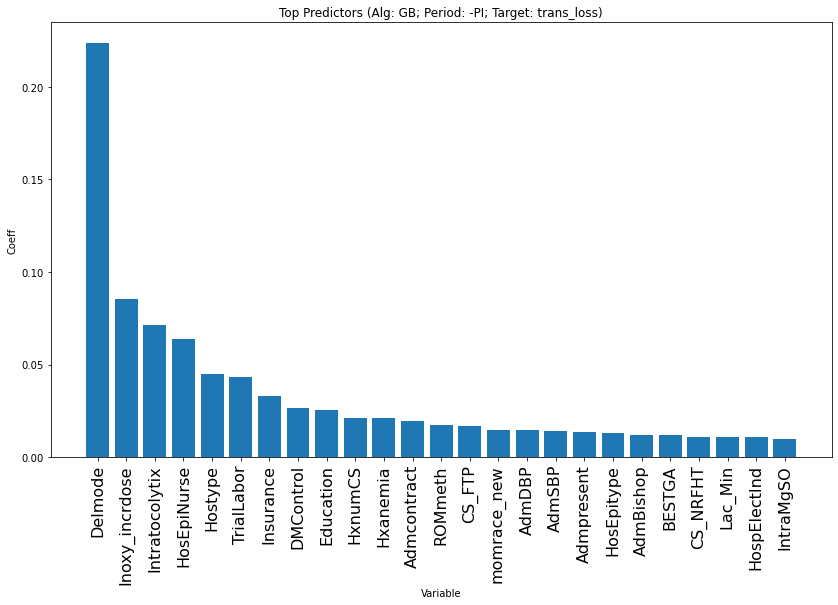

In [25]:
plt.rcParams["figure.figsize"] = (14, 8)
x_labels = top_pred.index.values[0:25]
print(x_labels)
fig, ax = plt.subplots(1,1)  # Create a figure and an axes.
ax.set_title('Top Predictors' + " (Alg: " + alg + "; Period: " + period + "; Target: " + targ + ")")
ax.bar(x_labels, top_pred.values[0:25])
ax.set_ylabel('Coeff')
ax.set_xlabel('Variable')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
#plt.xlim(1,20)
plt.show()

In [26]:
base = glob.escape(files[top_index][:-20])
print(base)
#base = glob.escape(base)
#print(base)

trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0


In [27]:
#path = inpath + alg + '/output/'
ft_glob = base + "*" + '_fpr_tpr.dat'
pr_glob = base + "*" + '_pr.dat'
pred_glob = base + "*" + '_pred.dat'
prob_glob = base + "*" + '_probs.dat'
print(glob.glob(ft_glob))
print(glob.glob(pr_glob))
print(glob.glob(pred_glob))
print(glob.glob(prob_glob))

['trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0-20210412_180116_fpr_tpr.dat']
['trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0-20210412_180116_pr.dat']
['trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0-20210412_180116_pred.dat']
['trans_loss-PI-Union50-RAND-GB-0.1_11_12_50_900_70_7_0.9-1-1.0-20210412_180116_probs.dat']


In [28]:
fpr, tpr, thresholds = np.loadtxt(glob.glob(ft_glob)[0], delimiter=',')
precision, recall, pr_thresh = np.loadtxt(glob.glob(pr_glob)[0], delimiter=',')
y_test, y_pred = np.loadtxt(glob.glob(pred_glob)[0], dtype=int, delimiter=',')
probs = np.loadtxt(glob.glob(prob_glob)[0], delimiter=',')
prob1 = probs[:,1]

In [29]:
probs

array([[0.9720441 , 0.0279559 ],
       [0.94723809, 0.05276191],
       [0.27647776, 0.72352224],
       ...,
       [0.30866299, 0.69133701],
       [0.80508952, 0.19491048],
       [0.93572599, 0.06427401]])

In [30]:
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [31]:
print(f'y_test.shape = {y_test.shape}')
print(f'prob1.shape = {prob1.shape}')

y_test.shape = (55624,)
prob1.shape = (55624,)


In [32]:
# roc_auc vs roc_auc_score
from sklearn.metrics import roc_auc_score, auc
roc_auc_s_prob = roc_auc_score(y_test, prob1)
roc_auc = auc(fpr, tpr)
print(f'roc_auc_s_prob = {roc_auc_s_prob}')
print(f'roc_auc(auc) = {roc_auc}')

roc_auc_s_prob = 0.8322872315094955
roc_auc(auc) = 0.8322872315094955


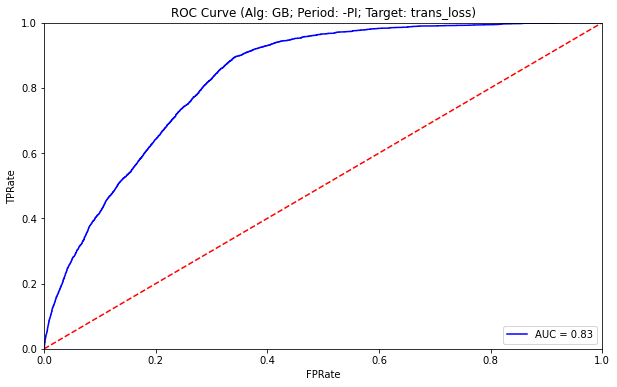

In [33]:
from sklearn.metrics import auc
plt.rcParams["figure.figsize"] = (10, 6)
roc_auc = auc(fpr, tpr)
plt.title("ROC Curve (Alg: " + alg + "; Period: " + period + "; Target: " + targ + ")")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPRate')
plt.xlabel('FPRate')
plt.show()

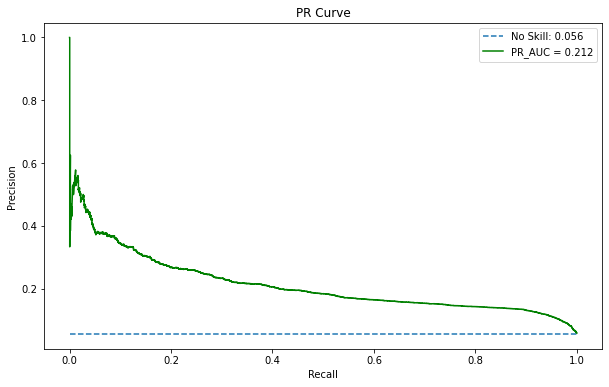

In [34]:
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle= '--', label= f'No Skill: {no_skill:.3f}')

pr_auc = auc(recall, precision)
plt.title('PR Curve')
plt.plot(recall, precision, 'g', label = 'PR_AUC = %0.3f' % pr_auc)
plt.legend(loc = 'upper right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, auc, roc_auc_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score, sensitivity_specificity_support
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
roc_auc_s_prob = roc_auc_score(y_test, prob1)
pr_auc = auc(recall, precision)
recall_s = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print(f' recall = {recall_s}')
print(f'   prec = {prec}')
print(f'    MCC = {mcc}')
print(f' PR_AUC = {pr_auc}')
print(f'ROC_AUC = {roc_auc_s_prob}')
# Note: pos_label does not appear to have any effect
gmean_none = geometric_mean_score(y_test, y_pred, average=None)
print(f'gmean_none    = {gmean_none}')
gmean_macro = geometric_mean_score(y_test, y_pred, average='macro')
print(f'gmean_macro   = {gmean_macro}')
sens, spec, ss_supp = sensitivity_specificity_support(y_test, y_pred, average=None)
print(f'sens   = {sens}')
print(f'spec   = {spec}')

[[34823 17698]
 [  347  2756]]
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     52521
           1       0.13      0.89      0.23      3103

    accuracy                           0.68     55624
   macro avg       0.56      0.78      0.51     55624
weighted avg       0.94      0.68      0.76     55624

 recall = 0.8881727360618756
   prec = 0.13474137088100127
    MCC = 0.2623574833291561
 PR_AUC = 0.211712946105347
ROC_AUC = 0.8322872315094955
gmean_none    = [0.76738855 0.76738855]
gmean_macro   = 0.77560138107334
sens   = [0.66303003 0.88817274]
spec   = [0.88817274 0.66303003]


In [36]:
print(len(y_test[y_test==1]))
print(len(y_test))

3103
55624


In [37]:
from sklearn.metrics import average_precision_score
print(f'PR_AUC = {pr_auc}')
print(f'AP     = {average_precision_score(y_test, prob1)}')

PR_AUC = 0.211712946105347
AP     = 0.21200283310464602


# Threshold Moving

In [38]:
prob1

array([0.0279559 , 0.05276191, 0.72352224, ..., 0.69133701, 0.19491048,
       0.06427401])

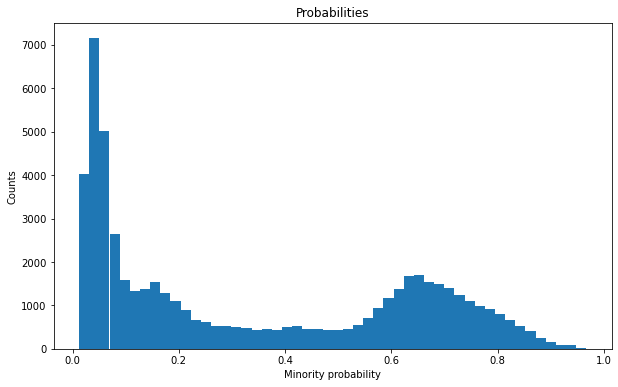

In [39]:
plt.title('Probabilities')
plt.hist(prob1, bins=50)
plt.ylabel('Counts')
plt.xlabel('Minority probability')
plt.show()

(6038,)


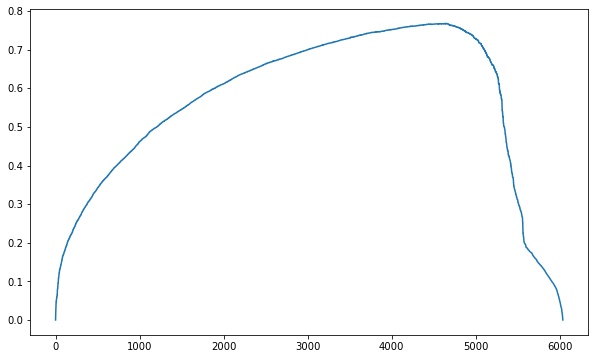

In [40]:
gmeans = np.sqrt(tpr * (1-fpr))
print(gmeans.shape)
plt.plot(gmeans)
plt.show()

In [41]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print(f'max_ix = {ix}')
print( ' Best Threshold=%f, G-mean=%.3f ' % (thresholds[ix], gmeans[ix]))

max_ix = 4633
 Best Threshold=0.498587, G-mean=0.768 


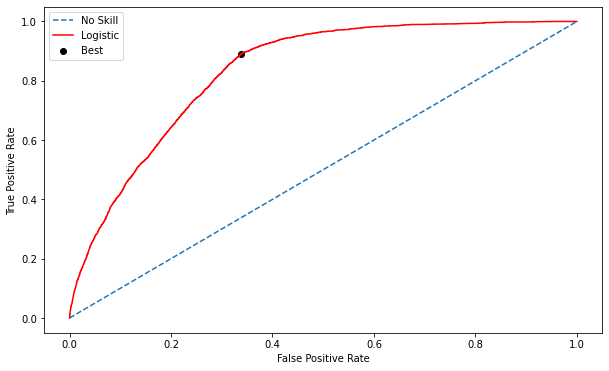

In [42]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, 'r', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [43]:
print(f'ix = {ix}; fpr[ix] = {fpr[ix]}; tpr[ix]={tpr[ix]}')

ix = 4633; fpr[ix] = 0.33769349403095905; tpr[ix]=0.8901063486948114


In [44]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print( ' Best Threshold=%f, F-measure=%.3f ' % (pr_thresh[ix], fscore[ix]))

 Best Threshold=0.747886, F-measure=0.273 


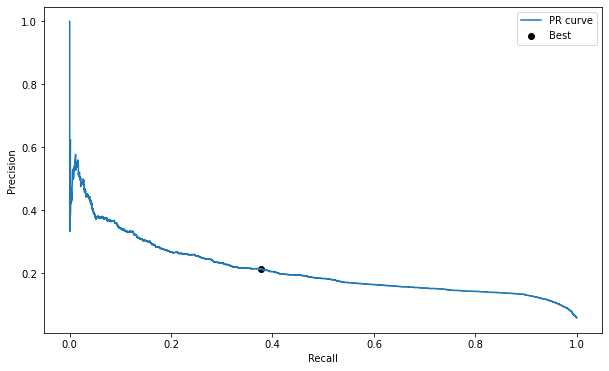

In [45]:
#no_skill = len(y_test[y_test==1]) / len(y_test)
#plt.plot([0,1], [no_skill,no_skill], linestyle= '--' , label= 'No Skill' )
plt.plot(recall, precision, label= 'PR curve' )
plt.scatter(recall[ix], precision[ix], marker= 'o' , color= 'black' , label= 'Best' )
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [46]:
print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, normalize='true'))
print(confusion_matrix(y_test, y_pred, normalize='pred'))
print(confusion_matrix(y_test, y_pred, normalize='all'))

[[34823 17698]
 [  347  2756]]
[[0.66303003 0.33696997]
 [0.11182726 0.88817274]]
[[0.99013364 0.86525863]
 [0.00986636 0.13474137]]
[[0.62604272 0.31817201]
 [0.00623831 0.04954696]]


In [47]:
print(f'top_index = {top_index}')
top_coeffs = pd.DataFrame(coeffs_df[top_index])
#top_coeffs = pd.DataFrame(coeffs_df[top_index], columns=['coeff'])
top_coeffs.rename(columns={top_index:'coeff'}, inplace=True)
top_coeffs.index.name = 'Variable'
top_coeffs.sort_values(by='coeff', ascending=False, inplace=True)
top_coeffs

top_index = 0


,coeff
Variable,
Delmode,0.2236
Inoxy_incrdose,0.0854
Intratocolytix,0.0714
HosEpiNurse,0.0638
Hostype,0.0449
TrialLabor,0.0436
Insurance,0.0334
DMControl,0.0266
Education,0.0257


## Calibration curves 

In [48]:
from sklearn.calibration import calibration_curve
def plot_calibration(name, y_test, prob1, bins=10, **kwargs):
    fop, mpv = calibration_curve(y_test, prob1, n_bins=bins)
    
    plt.plot(mpv, fop, label=name, **kwargs)
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.grid(True)

In [49]:
alg

'GB'

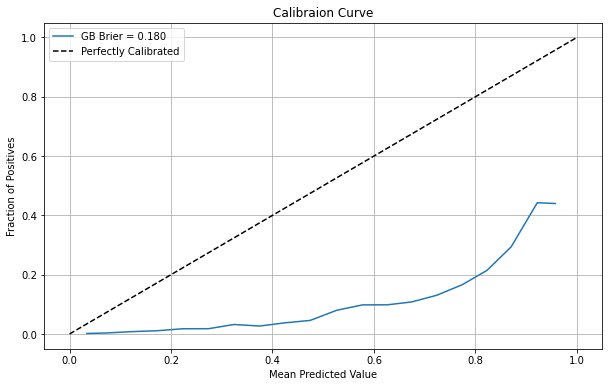

In [50]:
from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test, prob1)
plot_name = '{} Brier = {:.3f}'.format(alg, brier_score)
plot_calibration(plot_name, y_test, prob1, bins=20)
plt.plot([0,1],[0,1], linestyle='--', color='black', label='Perfectly Calibrated')
plt.title('Calibraion Curve')
plt.legend(loc='upper left')

## Note: Cramer comparison not working with high_EBL target 

# Compare Cramer to "top index" coefficients

In [51]:
cramfile =  cramer_df = '/MFMDatasets/MFM_bopf/data/csl/Cramer-corr-' + top_target + '.csv'
print(cramfile)
cramer_df = pd.read_csv(cramfile, header=None, index_col=0, names = ['Variable', 'Cramer_corr'])
cramer_df['Cramer_rank'] = cramer_df['Cramer_corr'].rank(ascending=False).astype(int)
cramer_df

NameError: name 'top_target' is not defined

In [ ]:
top_coeffs['coeff_rank'] = top_coeffs['coeff'].rank(ascending=False).astype(int)
top_coeffs

In [ ]:
print(top_index)
small.loc[top_index].head()

In [ ]:
top_target = small.loc[top_index]['target']
top_target

In [ ]:
compare_df = pd.merge(top_coeffs, cramer_df, how='inner', on='Variable')
compare_df

In [ ]:
#
# @author: Ritesh Agrawal
# @Date: 13 Feb 2013
# @Description: This is an implementation of rank biased overlap score 
# (Refererence: http://www.umiacs.umd.edu/~wew/papers/wmz10_tois.pdf). 
# This is a modified implementation of  https://github.com/maslinych/linis-scripts/blob/master/rbo_calc.py
# It is a linear implementation of the RBO and assumes there are no
# duplicates and doesn't handle for ties. 
#

def score(l1, l2, p = 0.98):
    """
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
    if l1 == None: l1 = []
    if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    # Equation 32
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext
    

In [ ]:
from scipy.stats import kendalltau, mannwhitneyu
# Calculate Rank-Based Overlap score
rbo = score(compare_df['Cramer_rank'].tolist(), compare_df['coeff_rank'].tolist())
print(f'rbo = {rbo}')
ken_tau = kendalltau(compare_df['Cramer_rank'].tolist(), compare_df['coeff_rank'].tolist())
print(f'ken_tau = {ken_tau}')
mann_whit = mannwhitneyu(compare_df['Cramer_rank'].tolist(), compare_df['coeff_rank'].tolist())
print(f'mann_whit = {mann_whit}')
print(f'CLF_time(min) = {combo.loc[top_index]["CLF_time(min)"]}')
print(f'{SORT_STAT} = {combo.loc[top_index][SORT_STAT]}')


In [ ]:
file = outdir + '/cramer_compare/' + alg + period + '-' + SORT_STAT + '-CramerCoeffComp.csv'
with open(file, 'w', newline='') as outfile:
    print(f'Algorithm, {alg}', file=outfile)
    print(f'Target, {top_target}', file=outfile)
    print(f'RBO, {rbo:.3f}', file=outfile)
    print(f'Kendall_tau, {ken_tau.correlation:.3f}', file=outfile)
    print(f'CLF_time(min) = {combo.loc[top_index]["CLF_time(min)"]}', file=outfile)
    print(f'{SORT_STAT} = {combo.loc[top_index][SORT_STAT]}\n', file=outfile)
#    print(f'MannWhitneyU, {mann_whit.statistic:.3f}\n', file=outfile)
    
if out_flag:
    compare_df.to_csv(file, mode='a', float_format='%0.6f')